In [5]:
# !pip install scikit-image
# !pip install opencv-python

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.utils import load_img, img_to_array, to_categorical
import cv2
from skimage.restoration import denoise_nl_means, estimate_sigma
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D
from keras.layers import Activation, Dropout, Flatten, Dense
#from keras.applications.efficientnet import EfficientNetB0, preprocess_input as preprocess_efficientnetB0
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as preprocess_resnet50
from keras.applications.inception_v3 import InceptionV3, preprocess_input as preprocess_inceptionv3
from keras.models import Model
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from keras.preprocessing.image import ImageDataGenerator

os.getcwd()

'C:\\Users\\jesse\\Documents\\MMA\\RSM8521\\RSM8521_FinalProject_Team6'

In [2]:
from tensorflow.keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2, VGG16, InceptionV3

### Data Preprocessing
To ensure the quality of the input data, we considered several preprocessing techniques that are specifically tailored for MRI images and have been widely used in neuroimaging research, including noise reduction, intensity normalization, and brain extraction. Each of these steps address different realistic challenges and reduce heterogeneities other than the key features from MRI images. These techniques will help ensure that the MRI data is suitable for machine learning models, improving their performance and generalization.<br>
1. **Noise reduction:**<br>
MRI images can contain noises, artifacts, or non-uniformities that could cause the model to overfit on these irrelevant/biased features.<br>

2. **Intensity normalization:**<br>
The intensity values of MRI images can vary across different scanners, subjects, or sessions. Therefore, normalization is essential for ensuring that the features extracted by the model are consistent across the dataset.<br>

### Increase Contrast

In [3]:
path_temp = f'Alzheimer_s Dataset/train/NonDemented/'

In [21]:
def contrast_adjustment(image):
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    adjusted_image = clahe.apply(img_gray)
    return cv2.cvtColor(adjusted_image, cv2.COLOR_GRAY2RGB)

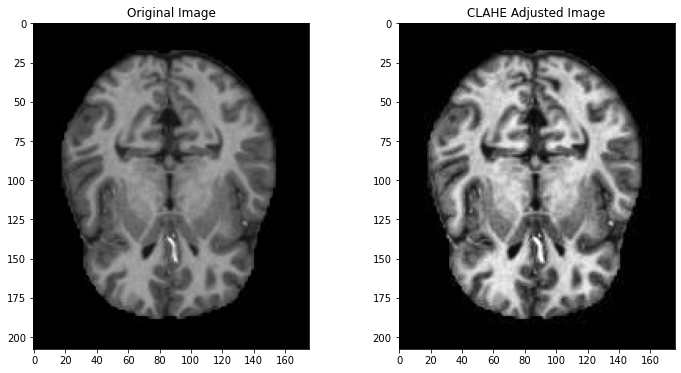

In [4]:
# Read the input image in grayscale
img = cv2.imread(path_temp + 'nonDem12.jpg', 0)

# Create a CLAHE object with specified parameters
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Apply CLAHE to the input image
clahe_img = clahe.apply(img)

# Display the original and adjusted images
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(clahe_img, cmap='gray')
plt.title('CLAHE Adjusted Image')

plt.show()

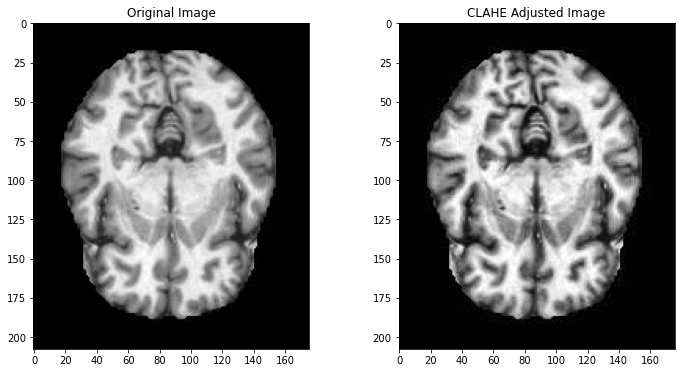

In [5]:
# Read the input image in grayscale
img = cv2.imread(path_temp + 'nonDem11.jpg', 0)

# Create a CLAHE object with specified parameters
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Apply CLAHE to the input image
clahe_img = clahe.apply(img)

# Display the original and adjusted images
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(clahe_img, cmap='gray')
plt.title('CLAHE Adjusted Image')

plt.show()

### Denoising

In [13]:
# noise reduction
def denoise_image(image, h=5):
    src = np.uint8(image)  # Convert image to 8-bit unsigned integers
    denoised_image = cv2.fastNlMeansDenoisingColored(src, None, h=h, templateWindowSize=7, searchWindowSize=21)
    return denoised_image

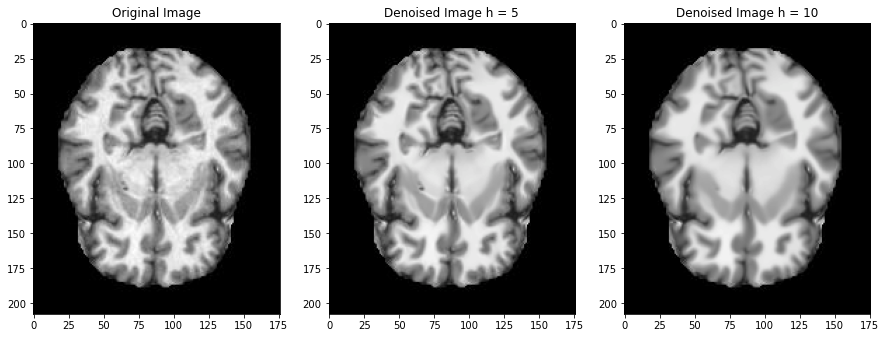

In [16]:
# Read the input image in grayscale
img = cv2.imread(path_temp + 'nonDem11.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Denoise the image
denoised_img_5 = denoise_image(img, h=5)
denoised_img_10 = denoise_image(img, h=10)

# Display the original and denoised images
plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(132)
plt.imshow(denoised_img_5)
plt.title('Denoised Image h = 5')

plt.subplot(133)
plt.imshow(denoised_img_10)
plt.title('Denoised Image h = 10')

plt.show()

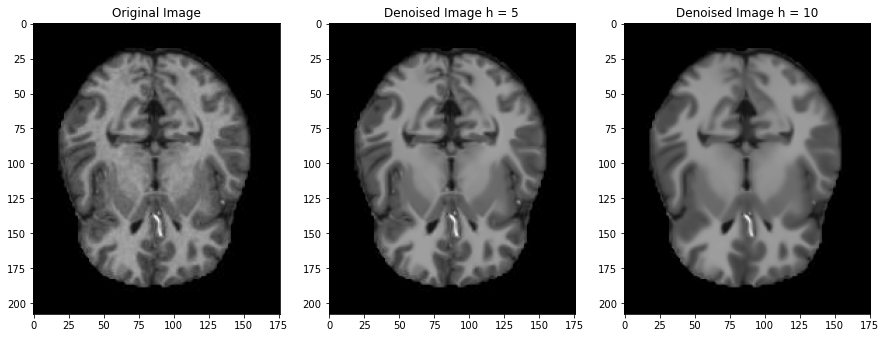

In [17]:
# Read the input image in grayscale
img = cv2.imread(path_temp + 'nonDem12.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Denoise the image
denoised_img_5 = denoise_image(img, h=5)
denoised_img_10 = denoise_image(img, h=10)

# Display the original and denoised images
plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(132)
plt.imshow(denoised_img_5)
plt.title('Denoised Image h = 5')

plt.subplot(133)
plt.imshow(denoised_img_10)
plt.title('Denoised Image h = 10')

plt.show()

### Normalizing Intensity

In [18]:
# intensity normalization
def normalize_intensity(image):
    original_shape = image.shape
    reshaped_img = image.reshape(-1,1)
    scaler = MinMaxScaler()
    normalized_image = scaler.fit_transform(reshaped_img)
    return normalized_image.reshape(original_shape)

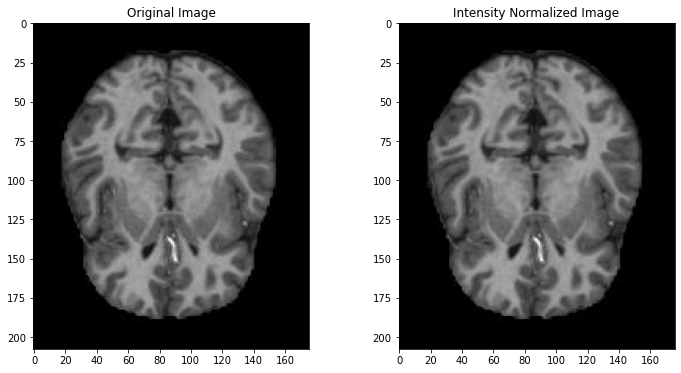

In [19]:
# Load the image in grayscale mode
img = cv2.imread(path_temp + 'nonDem12.jpg', cv2.IMREAD_GRAYSCALE)

# Normalize the intensity of the image
normalized_img = normalize_intensity(img)

# Display the original and normalized images
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(normalized_img, cmap='gray')
plt.title('Intensity Normalized Image')

plt.show()

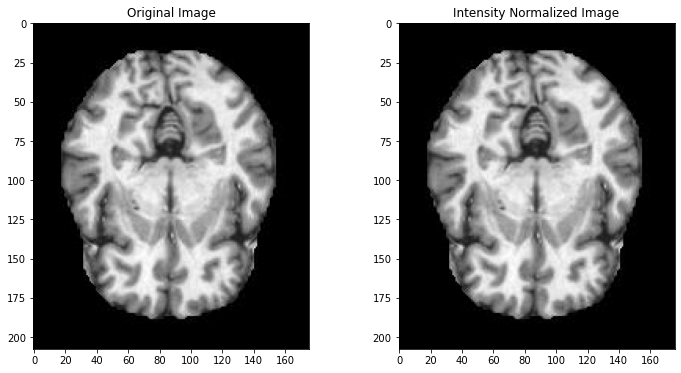

In [20]:
# Load the image in grayscale mode
img = cv2.imread(path_temp + 'nonDem11.jpg', cv2.IMREAD_GRAYSCALE)

# Normalize the intensity of the image
normalized_img = normalize_intensity(img)

# Display the original and normalized images
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(normalized_img, cmap='gray')
plt.title('Intensity Normalized Image')

plt.show()

#### Prepare data (applying preprocessing, whether to resize, and encode target variable for cross-validation)

In [25]:
# data path
# train_data_dir = 'c:\\Users\\zhenq\\OneDrive\\Documents\\UT_MMA\\RSM8521_AI\\Final_project\\Alzheimer_Dataset\\train'
# test_data_dir = 'c:\\Users\\zhenq\\OneDrive\\Documents\\UT_MMA\\RSM8521_AI\\Final_project\\Alzheimer_Dataset\\test'

# train_data_dir = r"C:\Users\Sam\Desktop\Master of Management Analytics\Spring-Term\RSM8521 - AI Analytics\Final Project\train"
# test_data_dir = r"C:\Users\Sam\Desktop\Master of Management Analytics\Spring-Term\RSM8521 - AI Analytics\Final Project\test"

train_data_dir = r'/Alzheimer_s Dataset/train'
test_data_dir = r'/Alzheimer_s Dataset/train'

In [26]:
# get dimensions if resize for the pre-trained model is needed
def get_size(model):
    """
    This function will instantiate the default image size used for training
    for the choice pre-trained model
        input: model choice - string
        output: img_width, img_height
    """
    if model == 'InceptionV3':
        img_width, img_height = 299, 299
    elif (model == 'ResNet50') | (model == 'VGG16'):
        img_width, img_height = 224, 224
    return img_width, img_height

In [27]:
# Choice of model: ResNet50, EfficientNetB0, InceptionV3
def load_img_data(data_dir, resize_option, resize_dim):
    """
    This function extracts image data, apply preprocess steps, and convert them into numpy array
        inputs: data_dir: data directory, train or test (string)
                resize_option: resize or keep orginal size (boolean)
                resize_width, resize_height: outputs from "get_size", only be used when resize_option is True; Otherwise, orginal size will be used
        output: numpy arrary of each image with associated label

    """
#     num_files_to_access = 200
    file_counter = 0

    images = []
    labels = []
    num_images_processed = 0
    for class_name in os.listdir(data_dir):
        class_folder = os.path.join(data_dir, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):

                '''
                The below code can help you extract only 200 images, for testing purpose
                '''
                # if file_counter >= num_files_to_access:
                #     break
                # print(filename)
                # file_counter += 1

                img_path = os.path.join(class_folder, filename)

                # Depending on the resize options specified at the beginning of the function, to choose whether or not to resize
                if resize_option == False:
                    img = load_img(img_path)
                else:
                    img = load_img(img_path, target_size=(resize_dim[0], resize_dim[1]), color_mode = 'rgb')
                img_array = img_to_array(img)

                # apply preprocessing
                denoised_image = denoise_image(img_array)
                contrast_adjusted_image = contrast_adjustment(denoised_image)
                normalized_image = normalize_intensity(contrast_adjusted_image)

                # append results to corresponding lists
                images.append(normalized_image)
                labels.append(class_name)

                num_images_processed += 1
                if num_images_processed % 100 == 0:
                    print(f"Processed {num_images_processed} images")

    return np.array(images), np.array(labels)

# Image Augmentation

In [28]:
# The desired image augmentation we want to apply 

datagen = ImageDataGenerator(
    rotation_range=15,      # Randomly rotate images by up to 10 degrees
    width_shift_range=0.05,  # Randomly shift images horizontally by up to 10% of the image width
    height_shift_range=0.5, # Randomly shift images vertically by up to 10% of the image height
    shear_range=0.05,        # Randomly shear images by up to 20%
    zoom_range=0.005,         # Randomly zoom images by up to 20%
    horizontal_flip=True,   # Randomly flip images horizontally
    vertical_flip=True,    # Do not flip images vertically
    brightness_range= (0.8, 1.2),
    fill_mode='nearest'     # Fill any missing pixels with the nearest pixel value
)

In [21]:
def augmentation_image(X_train, y_train, batch_size, augmentation_factor=0.5):
    '''
       This function takes Xtrain and Ytrain, which are two arrays. 
       Then, augment them based on the augmentation techniques we require above.  
    '''
    num_samples = X_train.shape[0]
    augmentation_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

    # Generate two empty arrays to store the information
    augmented_images = np.empty((0, *X_train.shape[1:]), dtype=X_train.dtype)
    augmented_labels = np.empty((0,), dtype=y_train.dtype)
    
    num_batches = num_samples // batch_size + 1
    total_batches = num_batches * augmentation_factor

    for i in range(total_batches):
        x_batch, y_batch = augmentation_generator.next()
        augmented_images = np.concatenate((augmented_images, x_batch))
        augmented_labels = np.concatenate((augmented_labels, y_batch))

    return augmented_images, augmented_labels

# Model Training

## Data Preparation before model training

`Monitor progress for image processing`

In [ ]:
resize_dim = get_size('ResNet50')

In [6]:
# Load data for training set
X_tr, y_tr = load_img_data(train_data_dir, False, resize_dim)
#X_te, y_te = load_img_data(test_data_dir, False, resize_dim)

mildDem0.jpg
mildDem1.jpg
mildDem10.jpg
mildDem100.jpg
mildDem101.jpg
mildDem102.jpg
mildDem103.jpg
mildDem104.jpg
mildDem105.jpg
mildDem106.jpg
mildDem107.jpg
mildDem108.jpg
mildDem109.jpg
mildDem11.jpg
mildDem110.jpg
mildDem111.jpg
mildDem112.jpg
mildDem113.jpg
mildDem114.jpg
mildDem115.jpg
mildDem116.jpg
mildDem117.jpg
mildDem118.jpg
mildDem119.jpg
mildDem12.jpg
mildDem120.jpg
mildDem121.jpg
mildDem122.jpg
mildDem123.jpg
mildDem124.jpg
mildDem125.jpg
mildDem126.jpg
mildDem127.jpg
mildDem128.jpg
mildDem129.jpg
mildDem13.jpg
mildDem130.jpg
mildDem131.jpg
mildDem132.jpg
mildDem133.jpg
mildDem134.jpg
mildDem135.jpg
mildDem136.jpg
mildDem137.jpg
mildDem138.jpg
mildDem139.jpg
mildDem14.jpg
mildDem140.jpg
mildDem141.jpg
mildDem142.jpg
mildDem143.jpg
mildDem144.jpg
mildDem145.jpg
mildDem146.jpg
mildDem147.jpg
mildDem148.jpg
mildDem149.jpg
mildDem15.jpg
mildDem150.jpg
mildDem151.jpg
mildDem152.jpg
mildDem153.jpg
mildDem154.jpg
mildDem155.jpg
mildDem156.jpg
mildDem157.jpg
mildDem158.jpg
mildD

In [24]:
# Change the target variable into one-hot encoding for softmax and gridsearch
label_encoder = LabelEncoder()

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_tr, y_tr, test_size=0.2, random_state=22)

# To integer first
y_train_int = label_encoder.fit_transform(y_train)
#y_test_int = label_encoder.transform(y_train)

# Convert integer labels to one-hot encoded format
y_train_encoded = to_categorical(y_train_int)
#y_test_encoded = to_categorical(y_test_int)

print(X_train.shape)
print(y_train_encoded.shape)

(160, 208, 176, 3)
(160, 1)


In [25]:
# In here, we want to augment the training dataset. 
# Now, the training dataset and y_train dataset are in array, with batch size of 32. 

batch_size = 32

X_train_aug, y_train_aug = augmentation_image(X_train,y_train,batch_size)
X_train, y_train

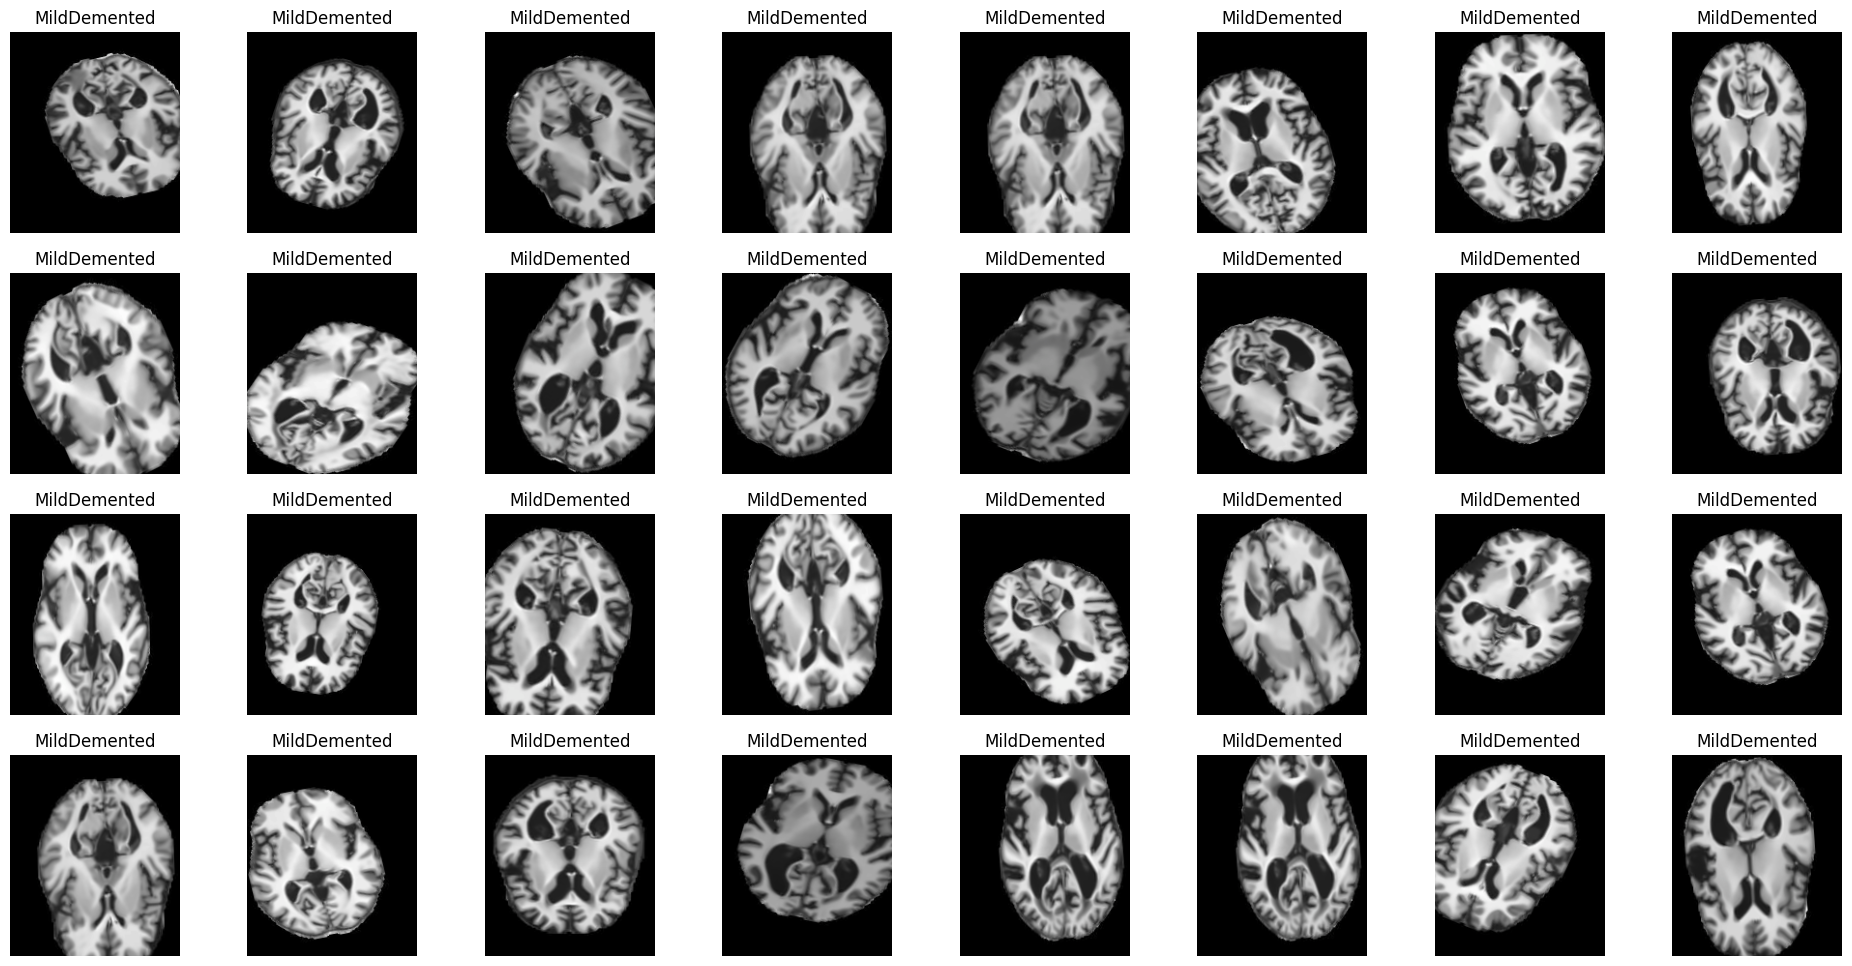

In [31]:
# Take a look at the images if you want to, randomly select images

num_images = 32
indices = np.random.choice(len(X_train), num_images)
images = X_train[indices]
labels = y_train[indices]


fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(24,12))
for i in range(4):
    for j in range(8):
        ax[i][j].imshow(images[i*8+j])
        ax[i][j].set_title(str(labels[i*8+j]))
        ax[i][j].axis('off')
plt.show()

## Actual Model

In [ ]:
def create_model(base_model, num_conv_layers=1, num_filters=32, filter_size=(3, 3), 
                 dropout_rate=0.5, use_custom_layers=True):
    """
    This function constructs the CNN model based on the specified pre-trained model
    and adds tailored, appropriate fully connected layers for each base model
    along with custom Conv2D layers and a GlobalAveragePooling2D layer, if enabled.
    """
    if base_model == 'ResNet50V2':
        base = ResNet50V2(weights='imagenet', include_top=False)
        fc_layer_size = 2048
    elif base_model == 'VGG16':
        base = VGG16(weights='imagenet', include_top=False)
        fc_layer_size = 4096
    elif base_model == 'InceptionV3':
        base = InceptionV3(weights='imagenet', include_top=False)
        fc_layer_size = 2048
    else:
        raise ValueError('Invalid base model')

    # Freeze the base model layers
    for layer in base.layers:
        layer.trainable = False

    # Fine-tune the model with custom layers
    x = base.output

    if use_custom_layers:
        for _ in range(num_conv_layers):
            x = Conv2D(num_filters, filter_size, padding='same', activation='relu')(x)
            x = Dropout(dropout_rate)(x)

        x = GlobalAveragePooling2D()(x)
    else:
        x = Flatten()(x)

    x = Dense(fc_layer_size, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(fc_layer_size, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(4, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Example usage
create_model('ResNet50V2', use_custom_layers=False).summary()

In [15]:
# # Create the main body of the model
# def create_model(base_model, num_conv_layers=1, num_filters=32, filter_size = (3,3), dropout_rate = 0.5):
#     """
#     This function construct the CNN model based on the specified pre-trainede modl 
#     and uses cross-validation to prform hyperparameter tuning

#     """
#     if base_model == 'ResNet50':
#         base = ResNet50(weights='imagenet', include_top=False)
#     elif base_model == 'VGG16':
#         base = VGG16(weights='imagenet', include_top=False)
#     elif base_model == 'InceptionV3':
#         base = InceptionV3(weights='imagenet', include_top=False)
#     else:
#         raise ValueError('Invalid base model')

#     # Freeze the base model layers
#     for layer in base.layers:
#         layer.trainable = False

#     # Fine-tune the model with custom layers
#     x = base.output

#     for _ in range(num_conv_layers):
#         x = Conv2D(num_filters, filter_size, padding = 'same', activation='relu')(x)
#         x = Dropout(dropout_rate)(x)

#     x = GlobalAveragePooling2D()(x)
#     predictions = Dense(4, activation='softmax')(x)

#     model = Model(inputs=base.input, outputs=predictions)

#     model.compile(optimizer=Adam(learning_rate = 1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

#     return model

# create_model('VGG16').summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [20]:
# use keras wrapper
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=16)

# hyperparameters to be searched
param_grid = {
    'base_model': ['ResNet50', 'VGG16'],
    'num_conv_layers': [1],
    'num_filters': [32],
    'filter_size': [(3, 3)],
    'dropout_rate': list(np.arange(0, 0.2, 0.1))  
}

# gridsearch
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

grid.fit(X_train, y_train_encoded)

# Evaluate performance
print("Best hyperparameters found: ", grid.best_params_)
best_model = grid.best_estimator_.model

C:\Users\zhenq\AppData\Local\Temp\ipykernel_20280\1673432784.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=16)


Epoch 1/10
205/205 [==============================] - 75s 346ms/step - loss: 1.0433 - accuracy: 0.5015
Epoch 2/10
 79/205 [==========>...................] - ETA: 43s - loss: 1.0227 - accuracy: 0.4834

KeyboardInterrupt: 

### Evaluate the model performance

In [ ]:
def evaluate_model(runs=5):
    scores = [] 
    for i in range(runs):
        print('Executing run %d' % (i+1))
        model = create_model() # input the best parameters found in the previous gridsearch
        model.fit(X_test,
                  callbacks=[],
                  epochs=epochs, verbose=0)
        print(' * Evaluating model on test set')
        scores.append(model.evaluate(y_test_encoded, 
                                     steps = y_test_encoded.shape[0] // batch_size,
                                     verbose=0))
        print(' * Test set Loss: %.4f, Accuracy: %.4f' % (scores[-1][0], scores[-1][1]))
        
    accuracies = [score[1] for score in scores]     
    return np.mean(accuracies), np.std(accuracies)
        
mean_accuracy, std_accuracy = evaluate_model(runs=5)

### Only use if tuning for pre-trained model specific preprocess steos - not suitable for our case

In [ ]:
# For preprocess the data based on different models, we customize a transformer to be included in the pipeline
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, base_model):
        self.base_model = base_model

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        preprocess_dict = {
            'ResNet50': preprocess_resnet50,
            'EfficientNetB0': preprocess_efficientnetB0,
            'InceptionV3': preprocess_inceptionv3
        }
        preprocess_input = preprocess_dict[self.base_model]
        return preprocess_input(X)

# Create preprocessing pipeline
preprocess_pipeline = Pipeline([
    ('preprocessor', Preprocessor(base_model='ResNet50')),
    ('final_model', KerasClassifier(build_fn=create_model, epochs=10, batch_size=16))
])
